# Import Libraries

In [105]:
# Standard libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 300)

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# for grouping the location of birds
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
!pip install pycountry_convert
import pycountry_convert as pc

# for audio
from IPython.display import Audio
import librosa
import random

# for file access
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load training data csv file

In [106]:
df = pd.read_csv('/content/drive/MyDrive/207/207-Project/data/test_metadata.csv')

df.head()

,primary_label,common_name,scientific_name,species_rank,filename,dataset,duration_secs,duration_mins,duration_hrs,species_total_files,...,rating,latitude,longitude,author,url,license,class_weight_file,class_weight_duration,class_weight_combined,orig_index
0,thrnig1,Thrush Nightingale,Luscinia luscinia,0,thrnig1/XC112492.ogg,test,58.540408,0.975673,0.016261,499,...,3.0,59.8510,17.6230,Sander Bot,https://www.xeno-canto.org/112492,Creative Commons Attribution-NonCommercial-Sha...,0.937876,0.419757,0.627439,13847
1,thrnig1,Thrush Nightingale,Luscinia luscinia,0,thrnig1/XC132295.ogg,test,73.769796,1.229497,0.020492,499,...,3.0,56.0889,47.2543,Albert Lastukhin,https://www.xeno-canto.org/132295,Creative Commons Attribution-NonCommercial-Sha...,0.937876,0.419757,0.627439,13856
2,thrnig1,Thrush Nightingale,Luscinia luscinia,0,thrnig1/XC133558.ogg,test,78.759229,1.312654,0.021878,499,...,4.5,61.5650,29.5650,Stuart Fisher,https://www.xeno-canto.org/133558,Creative Commons Attribution-NonCommercial-Sha...,0.937876,0.419757,0.627439,13859
3,thrnig1,Thrush Nightingale,Luscinia luscinia,0,thrnig1/XC134265.ogg,test,394.187755,6.569796,0.109497,499,...,5.0,51.3506,23.0467,Jarek Matusiak,https://www.xeno-canto.org/134265,Creative Commons Attribution-NonCommercial-Sha...,0.937876,0.419757,0.627439,13860
4,thrnig1,Thrush Nightingale,Luscinia luscinia,0,thrnig1/XC135792.ogg,test,42.344535,0.705742,0.011762,499,...,3.0,56.7542,46.8450,Albert Lastukhin,https://www.xeno-canto.org/135792,Creative Commons Attribution-NonCommercial-Sha...,0.937876,0.419757,0.627439,13866


# clean-up the csv file to match with train_val.csv

## drop samples with less than 8 seconds in length

In [107]:
len(df)

1402

In [108]:
# drop the samples with less than 8 seconds in duration
df = df[df['duration_secs'] >= 8]

In [109]:
len(df)

1253

## keep only columns of interest

In [110]:
columns = ['primary_label', 'filename', 'duration_secs', 'type', 'filename_npy', 'rating', 'latitude','longitude']
df = df[columns]
df.head()

,primary_label,filename,duration_secs,type,filename_npy,rating,latitude,longitude
0,thrnig1,thrnig1/XC112492.ogg,58.540408,['song'],thrnig1/XC112492.npy,3.0,59.8510,17.6230
1,thrnig1,thrnig1/XC132295.ogg,73.769796,"['male', 'song']",thrnig1/XC132295.npy,3.0,56.0889,47.2543
2,thrnig1,thrnig1/XC133558.ogg,78.759229,"['male', 'song']",thrnig1/XC133558.npy,4.5,61.5650,29.5650
3,thrnig1,thrnig1/XC134265.ogg,394.187755,['song'],thrnig1/XC134265.npy,5.0,51.3506,23.0467
4,thrnig1,thrnig1/XC135792.ogg,42.344535,"['male', 'song']",thrnig1/XC135792.npy,3.0,56.7542,46.8450


## keep only 3 species for inference

In [111]:
species = ['eaywag1', 'comsan', 'barswa']

In [112]:
df = df[df['primary_label'].isin(species)]

In [113]:
len(df)

381

## change the type to either blank, 'song', 'call', or 'both'

In [114]:
df.loc[df['type'].str.contains('call') & df['type'].str.contains('song'), 'type'] = 'both'
df.loc[df['type'].str.contains('call'), 'type'] = 'call'
df.loc[df['type'].str.contains('song|Song'), 'type'] = 'song'
df.loc[df['type'] == "['']", 'type'] = 'blank'
df.loc[(df['type'] != 'call') & (df['type'] != 'song') & (df['type'] != 'blank') & (df['type'] != 'both'), 'type'] = 'blank'

In [115]:
df['type'].value_counts().head(10)

call     230
song      56
blank     53
both      42
Name: type, dtype: int64

## change rating to binary

In [116]:
df['rating'] = np.where(df['rating'] >= 3.0, 'good', 'poor')

In [117]:
df['rating'].value_counts()

good    319
poor     62
Name: rating, dtype: int64

## add the geolocation attributes

### add a new column in df for the country location of each sample

In [118]:
df['latitude'].isnull().sum()

5

In [119]:
df['longitude'].isnull().sum()

5

In [120]:
locations = df[['latitude', 'longitude']].values

In [121]:
countries = []

for location in locations:
  geolocator = Nominatim(user_agent="<APP_NAME>", timeout=10)
  geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1)
  if np.isnan(location[0]) or np.isnan(location[1]):
    country = 'Unknown'
  else:
    locate = geocode(location, language='en')
    if locate is None:
      country = 'Antarctica'
    elif 'address' in locate.raw and 'country_code' in locate.raw['address']:
      country = locate.raw['address']['country_code']
    elif 'address' in locate.raw:
      country = locate.raw['address']
    else:
      country = 'Unknown'
  country = country.upper()
  countries.append(country)


In [122]:
assert len(df) == len(countries)

In [123]:
df['country'] = countries

In [124]:
# take a look at the different countries
df['country'].value_counts()

ES         48
FR         47
RU         31
GB         28
PL         22
PT         19
SE         17
DE         15
NL         14
IE         13
US          9
BE          9
MX          9
KZ          9
CN          8
NO          7
UA          7
AT          7
IT          6
FI          6
EE          5
UNKNOWN     5
DK          4
BG          3
CH          3
HN          2
ZA          2
CY          2
BR          2
HR          2
JP          2
LK          2
UZ          2
SG          1
ID          1
GE          1
MY          1
IN          1
GR          1
CZ          1
CD          1
TH          1
PA          1
CA          1
HU          1
TR          1
TW          1
Name: country, dtype: int64

In [125]:
# take a look at the rows with 'Unknown' country
df[['primary_label', 'latitude', 'longitude','country']][df['country'] == 'UNKNOWN']


,primary_label,latitude,longitude,country
602,barswa,NaN,NaN,UNKNOWN
604,barswa,NaN,NaN,UNKNOWN
615,barswa,NaN,NaN,UNKNOWN
616,barswa,NaN,NaN,UNKNOWN
622,barswa,NaN,NaN,UNKNOWN


In [126]:
# confirmed all labels with unknown country are due to missing latitude and longitude info
assert len(df[df['country']=='UNKNOWN']) == df['longitude'].isnull().sum()

### add a new column in df for the continent location of each sample

In [127]:
continents = []

for country in countries:
  if country == 'UNKNOWN':
    continent = 'UNKNOWN'
  else:
    continent = pc.country_alpha2_to_continent_code(country)
  continents.append(continent)

In [128]:
assert len(continents) == len(countries)

In [129]:
assert len(continents) == len(df)

In [130]:
df['continent'] = continents

In [131]:
# confirmed all labels with unknown country are in unknown continent
df[['primary_label', 'country','continent']][df['country'] == 'UNKNOWN']

,primary_label,country,continent
602,barswa,UNKNOWN,UNKNOWN
604,barswa,UNKNOWN,UNKNOWN
615,barswa,UNKNOWN,UNKNOWN
616,barswa,UNKNOWN,UNKNOWN
622,barswa,UNKNOWN,UNKNOWN


In [132]:
# take a look at the different continents
df['continent'].value_counts()

EU         316
AS          33
NA          22
UNKNOWN      5
AF           3
SA           2
Name: continent, dtype: int64

In [133]:
# since there are only a handful in NA and SA, let's just group them with NA as Americas
df.loc[df['continent']== 'NA', 'continent'] = 'AMERICAS'
df.loc[df['continent'] == 'SA', 'continent'] = 'AMERICAS'
df.loc[df['continent'] == 'EU', 'continent'] = 'EUROPE'
df.loc[df['continent'] == 'AS', 'continent'] = 'ASIA'
df.loc[df['continent'] == 'AF', 'continent'] = 'AFRICA'

In [134]:
df['continent'].value_counts()

EUROPE      316
ASIA         33
AMERICAS     24
UNKNOWN       5
AFRICA        3
Name: continent, dtype: int64

### Confirm the df is as expected and drop the latitude/longitude columns

In [135]:
df.head()

,primary_label,filename,duration_secs,type,filename_npy,rating,latitude,longitude,country,continent
299,eaywag1,eaywag1/XC131436.ogg,14.027755,call,eaywag1/XC131436.npy,good,44.6450,-1.0337,FR,EUROPE
300,eaywag1,eaywag1/XC132637.ogg,40.359229,call,eaywag1/XC132637.npy,good,52.8729,20.6474,PL,EUROPE
301,eaywag1,eaywag1/XC133615.ogg,13.505351,call,eaywag1/XC133615.npy,poor,56.1297,47.3682,RU,EUROPE
303,eaywag1,eaywag1/XC138886.ogg,54.987755,song,eaywag1/XC138886.npy,poor,54.9666,46.5573,RU,EUROPE
304,eaywag1,eaywag1/XC145084.ogg,10.605760,call,eaywag1/XC145084.npy,good,50.6639,69.9726,KZ,ASIA


In [136]:
df.drop(['latitude','longitude'], axis=1, inplace=True)

In [137]:
df.head()

,primary_label,filename,duration_secs,type,filename_npy,rating,country,continent
299,eaywag1,eaywag1/XC131436.ogg,14.027755,call,eaywag1/XC131436.npy,good,FR,EUROPE
300,eaywag1,eaywag1/XC132637.ogg,40.359229,call,eaywag1/XC132637.npy,good,PL,EUROPE
301,eaywag1,eaywag1/XC133615.ogg,13.505351,call,eaywag1/XC133615.npy,poor,RU,EUROPE
303,eaywag1,eaywag1/XC138886.ogg,54.987755,song,eaywag1/XC138886.npy,poor,RU,EUROPE
304,eaywag1,eaywag1/XC145084.ogg,10.605760,call,eaywag1/XC145084.npy,good,KZ,ASIA


# take a look at the distribution of total duration for each species

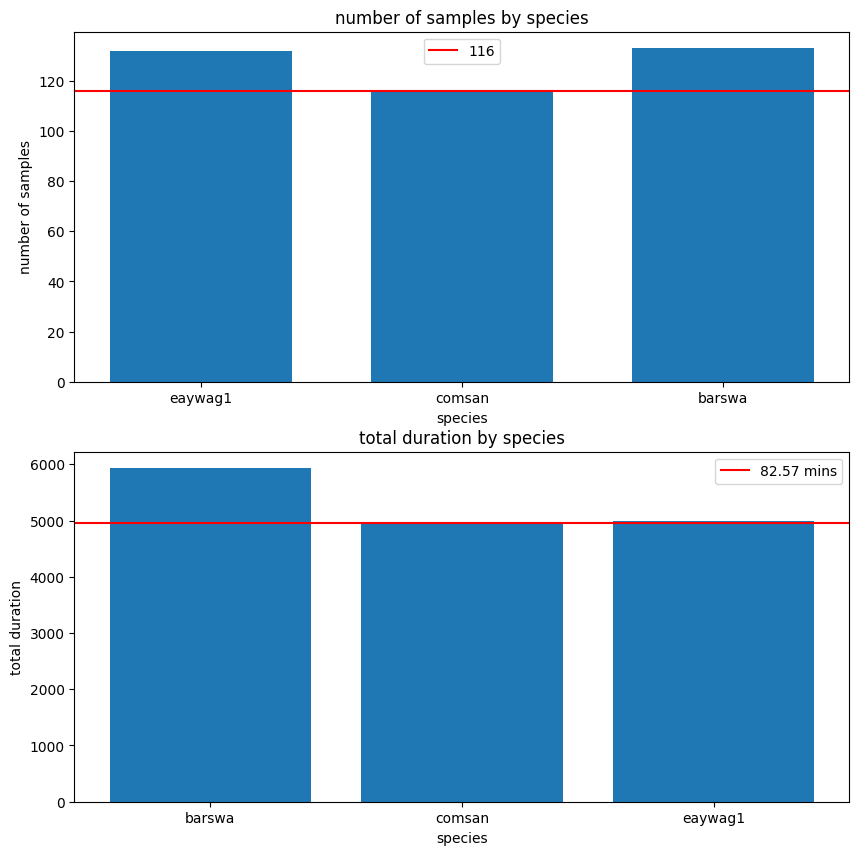

In [138]:
duration_sum_by_species = df[['primary_label', 'duration_secs']].groupby('primary_label').sum('duration_secs').reset_index()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
bins = bins = np.arange(4) - 0.5

axes[0].hist(df['primary_label'], rwidth=0.7, bins=bins)
axes[0].axhline(y=df['primary_label'].value_counts().min(), color='r', label=df['primary_label'].value_counts().min())
axes[0].legend()
axes[0].set_xlabel('species')
axes[0].set_ylabel('number of samples')
axes[0].set_title('number of samples by species')

axes[1].bar(duration_sum_by_species['primary_label'], duration_sum_by_species['duration_secs'])
axes[1].axhline(y=duration_sum_by_species.duration_secs.min(), color='r', label=f'{round(duration_sum_by_species.duration_secs.min()/60,2)} mins')
axes[1].legend()
axes[1].set_xlabel('species')
axes[1].set_ylabel('total duration')
axes[1].set_title('total duration by species')

plt.show()

# Save the df with librosa_loaded to replace original csv

In [139]:
df.to_csv('/content/drive/MyDrive/207/207-Project/notebooks/RG/3_species/test.csv', index=False)